In [1]:
using Distributions, Random
using LinearAlgebra

using Distributed
using MAT
using Plots
using Images

include("./basic_unmixing.jl");
# include("./gradient_projection_method.jl");
# include("./log_barrier_method.jl");

In [2]:
pyplot()
filename = "../project_data.mat"
file = matopen(filename)
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

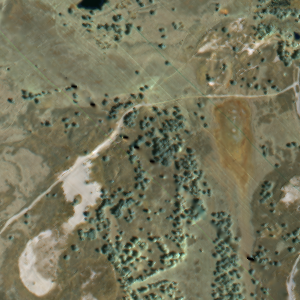

In [24]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB, permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

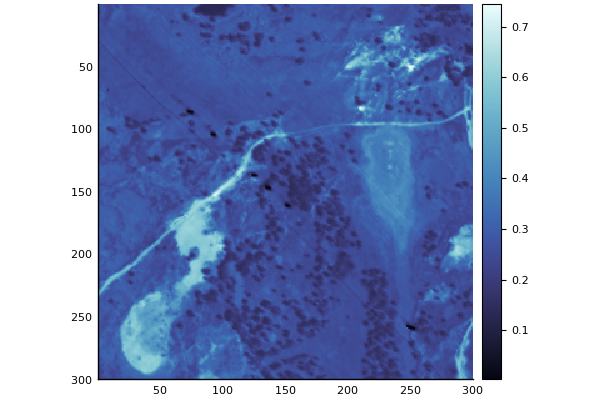

In [25]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

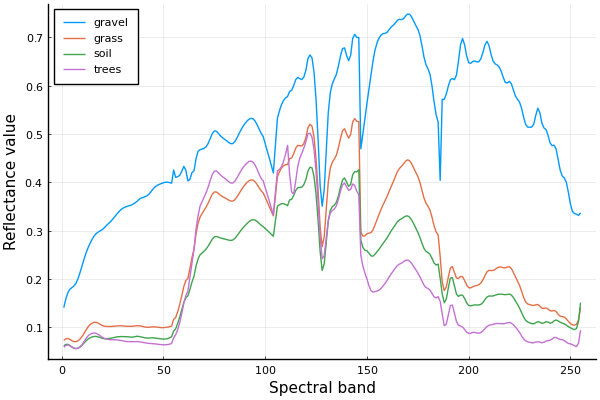

In [26]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

## Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [54]:
n = 25^2
p = 4
l = 255
k = floor(Int, sqrt(n))

# Use a small crop of the image first
offset_x = 200
offset_y = 0
img_small = img[offset_x:offset_x + k,offset:offset + k,:]

# X = reshape(img_small, (l , n))
X = img_small
S = sources;

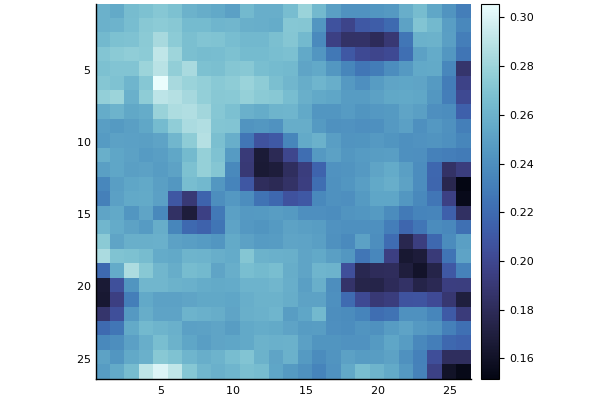

In [55]:
original_plot = heatmap(X[:, :, 150], aspect_ratio=1, yflip = true, c=:ice)

# Projected Gradient (single constraint)

In [56]:
include("./basic_unmixing.jl");
new_X_1c, A_1c = projected_gradient(X, S);

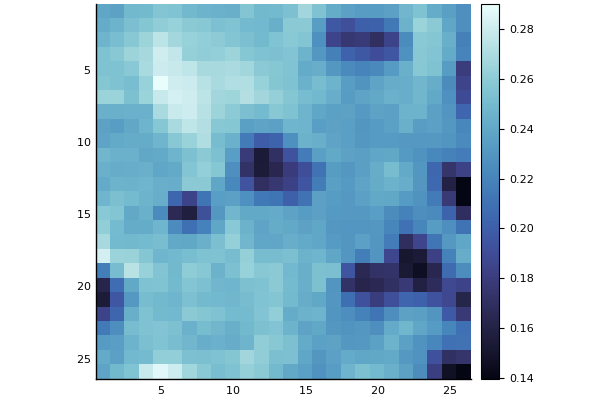

In [57]:
pg_1c_plot = heatmap(new_X_1c[:, :, 150], aspect_ratio=1, yflip = true, c=:ice)

In [58]:
get_distance(X, new_X_1c)

35.586257643218744

# Gradient projection method for linear constraint

In [59]:
include("./gradient_projection_method.jl");
new_X_2c, A_2c = projected_gradient_antoine(X, S);

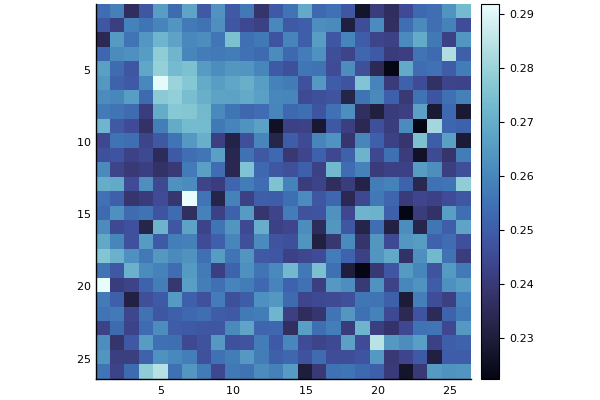

In [60]:
pg_12c_plot = heatmap(new_X_2c[:, :, 150], aspect_ratio=1, yflip = true, c=:ice) 

In [61]:
get_distance(X, new_X_2c)

451.3105557116926

In [100]:
is_feasible(B[:,450])

true

# Log-barrier method

In [ ]:
include("./log_barrier_method.jl")
new_X_lb, A_lb = log_barrier(X, S);

In [ ]:
lb_plot = heatmap(new_X_lb[:, :, 150],aspect_ratio=1, yflip = true,c=:ice)

In [113]:
is_feasible(C[:,450])

true

In [111]:
cost(X,S,C)

1630.3017122322315